# Lab 09 – Adversarial Robustness

Security and robustness of machine learning models have traditionally been often overlooked. It is usually quite easy for an adversary to create inputs (e.g. images) that look much like the originals to a human, but fool an ML model into thinking they are something else.

![Illustration from Goodfellow et al. Adding imperceptible pixel-wise perturbations to an image can drastically alter a model's predictions.](https://miro.medium.com/max/573/1*Nj_toOwx_Hc5NLn97Jv-ww.png)

In this lab, we will see that tiny perturbations to an image can cause drastically different model predictions. You will train two different image classifiers for hand-written digits: a logistic regression model and a neural net. For both, you will run the [Fast Gradient Sign Attack (FGSM)](https://arxiv.org/pdf/1412.6572.pdf), to try to fool them. Which one do you think will be more robust?

Making machine learning models provably robust against any attack is still an open area of research, but in the second part of this lab, we will explore if we can make the models robust against the attacks conducted in the first part.

A few notes:
- If you're interested to read more, note that research on adversarial examples is not limited to the image domain, check out [this attack](https://arxiv.org/pdf/1801.01944.pdf) on speech-to-text models.
- This lab is based on an official PyTorch tutorial on [Aversarial Example Generation](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).

## 1. Training a digit classifier
-------------------------

We will start by implementing a simple classifier for 28x28 black-and-white images of handwritten digits (the MNIST dataset).

In [6]:
%matplotlib inline
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

### Implementing the `accuracy` function

We will evaluate the quality of a classifier by its accuracy on the test set.

__Exercise__ As a warm-up exercise, please complete the accuracy-function below and make sure that the tests pass.

In [7]:
def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels

    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute accuracy based on `predicted_logits` and `reference`
    # ***************************************************
    # Get the predicted class indices by finding the index of the maximum logit
    predicted_classes = torch.argmax(predicted_logits, dim=1)

    # Compare the predicted classes to the reference labels
    correct_predictions = (predicted_classes == reference).float()

    # Compute the accuracy as the mean of correct predictions
    return correct_predictions.mean()


def test_accuracy():
    predictions = torch.tensor([[0.5, 1.0, 0.7], [-0.6, -0.3, 0]])
    correct_labels = torch.tensor([0, 2])  # first is wrong, second is correct
    print()
    assert accuracy(predictions, correct_labels).allclose(torch.tensor([0.5]))

    predictions = torch.tensor([[0.5, 1.0, 0.7], [-0.6, -0.3, 0], [-1, 0, 1]])
    correct_labels = torch.tensor([1, 1, 2])  # correct, wrong, correct
    assert accuracy(predictions, correct_labels).allclose(torch.tensor([2 / 3]))

    print("Tests passed")


test_accuracy()


Tests passed


### Logistic regression in PyTorch

__Exercise__ Complete the PyTorch model below for logistic regression.
Note that the model has 10 target classes, and therefore 10 outputs.
Do not include the non-linear transformation like the softmax function. In PyTorch, this transformation is usually included in the loss function (`CrossEntropyLoss`).

In [8]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.image_area = 28 * 28  # pixels
        self.num_classes = 10
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: create a linear transformation layer (with biases)
        # ***************************************************
        self.linear_transform = (
            torch.nn.Linear(self.image_area, self.num_classes)
        )  # TODO: call an appropriate pytorch function with the right arguments

    def forward(self, x):
        batch_size = x.shape[0]
        flattened_images = x.view(batch_size, self.image_area)
        return self.linear_transform(flattened_images)

__Exercise__ Complete the training function below and train the logistic regression model.

In [9]:
def train(model, criterion, dataset_train, dataset_test, optimizer, num_epochs):
    """
    @param model: torch.nn.Module
    @param criterion: torch.nn.modules.loss._Loss
    @param dataset_train: torch.utils.data.DataLoader
    @param dataset_test: torch.utils.data.DataLoader
    @param optimizer: torch.optim.Optimizer
    @param num_epochs: int
    """
    print("Starting training")
    for epoch in range(num_epochs):
        # Train an epoch
        model.train()
        for batch_x, batch_y in dataset_train:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # ***************************************************
            # INSERT YOUR CODE HERE
            # ***************************************************
            # Evaluate the network (forward pass)
            # TODO: insert your code here

            # Compute the gradient
            # TODO: insert your code here

            # Update the parameters of the model with a gradient step
            # TODO: insert your code here
            # Forward pass
            predictions = model(batch_x)

            # Compute loss
            loss = criterion(predictions, batch_y)

            # Backward pass: Compute gradients
            loss.backward()

            # Update the parameters with the optimizer
            optimizer.step()

            # Clear gradients for the next batch
            optimizer.zero_grad()

        # Test the quality on the test set
        model.eval()
        accuracies_test = []
        for batch_x, batch_y in dataset_test:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            accuracies_test.append(accuracy(prediction, batch_y))

        print(
            "Epoch {} | Test accuracy: {:.5f}".format(
                epoch, sum(accuracies_test).item() / len(accuracies_test)
            )
        )

In [10]:
num_epochs = 10
learning_rate = 1e-3
batch_size = 1000

dataset_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "../data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=100,
    shuffle=True,
)
dataset_train = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "../data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# If a GPU is available (should be on Colab, we will use it)
if not torch.cuda.is_available():
    raise Exception(
        "Things will go much quicker if you enable a GPU in Colab under 'Runtime / Change Runtime Type'"
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the logistic regression model with the Adam optimizer
criterion = (
    torch.nn.CrossEntropyLoss()
)  # this includes LogSoftmax which executes a logistic transformation
model_logreg = LogisticRegressionModel().to(device)

optimizer = torch.optim.Adam(model_logreg.parameters(), lr=learning_rate)
train(model_logreg, criterion, dataset_train, dataset_test, optimizer, num_epochs)

# You should expect a test accuracy of around 91%.
# Training should take around a minute

Using downloaded and verified file: ../data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.07MB/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Starting training
Epoch 0 | Test accuracy: 0.83570
Epoch 1 | Test accuracy: 0.87130
Epoch 2 | Test accuracy: 0.88680
Epoch 3 | Test accuracy: 0.89590
Epoch 4 | Test accuracy: 0.90010
Epoch 5 | Test accuracy: 0.90500
Epoch 6 | Test accuracy: 0.90650
Epoch 7 | Test accuracy: 0.90970
Epoch 8 | Test accuracy: 0.91070
Epoch 9 | Test accuracy: 0.91240


### A small convolutional network

__Exercise__ Now, use the tools you built before to train this simple Convolutional Network. The following architecture can give reasonable results on MNIST:
* first convolutional layer: 5x5 convolutions and 10 feature maps,
* second convolutional layer: 5x5 convolutions and 20 feature maps,
* dropout probability: 50%,
* first fully-connected layer: 50 hidden units.

In [11]:
class LeNetModel(torch.nn.Module):
    def __init__(self):
        """From: LeCun et al., 1998. Gradient-Based Learning Applied to Document Recognition"""
        super().__init__()
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)# TODO
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)# TODO
        self.conv2_drop = nn.Dropout(p=0.5)# TODO
        self.fc1 = nn.Linear(320, 50)# TODO
        self.fc2 = nn.Linear(50, 10)# TODO

    def forward(self, x):
        relu = torch.nn.functional.relu
        max_pool2d = torch.nn.functional.max_pool2d

        x = relu(max_pool2d(self.conv1(x), 2))
        x = relu(max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return x  # Previously there was torch.nn.functional.log_softmax(x, dim=1) here which was incorrect (although the network could still train)

In [12]:
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)

train(model_lenet, criterion, dataset_train, dataset_test, optimizer, num_epochs)

# Expect roughly 97% accuracy on the test set.
# Training should take around two minutes

Starting training
Epoch 0 | Test accuracy: 0.89310
Epoch 1 | Test accuracy: 0.93790
Epoch 2 | Test accuracy: 0.95430
Epoch 3 | Test accuracy: 0.96490
Epoch 4 | Test accuracy: 0.96850
Epoch 5 | Test accuracy: 0.97390
Epoch 6 | Test accuracy: 0.97750
Epoch 7 | Test accuracy: 0.97860
Epoch 8 | Test accuracy: 0.98150
Epoch 9 | Test accuracy: 0.98150



## 2. The Fast Gradient Sign Attack
-------------------------

One of the first and most popular adversarial attacks to date is
referred to as the [Fast Gradient Sign Attack](https://arxiv.org/abs/1412.6572) and is described by Goodfellow et. al. in their paper 'Explaining and Harnessing Adversarial Examples'. The attack is remarkably simple, and yet often sufficient to generate successful adversarial examples for many standardly trained models. The main idea is that rather than working to __minimize__ the loss by adjusting the __model parameters__ based on the backpropagated gradients, the attack optimizes the __input data__ to __maximize__ the loss. In other words, the attack computes the gradient of the loss w.r.t the input data, then adjusts the input data to maximize this loss.

![Illustration from Goodfellow et al. Adding imperceptible pixel-wise perturbations to an image can drastically alter a model's predictions.](https://miro.medium.com/max/573/1*Nj_toOwx_Hc5NLn97Jv-ww.png)

In the figure above, $\mathbf{x}$ is the original input image
correctly classified as a “panda”, $y$ is the ground truth label
for $\mathbf{x}$, $\mathbf{\theta}$ represents the model
parameters, and $J(\mathbf{\theta}, \mathbf{x}, y)$ is the loss
that is used to train the network. The attack backpropagates the
gradient back to the input data to calculate
$\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$. Then, it adjusts
the input data by a small step ($\epsilon$ or $0.007$ in the
picture) in the direction (i.e. $sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$) that will
maximize the loss with respect to the $L_\infty$ norm. The resulting perturbed image, $x'$, is then *misclassified* by the target network as a “gibbon” when it is still
clearly a “panda”.

### Update rule

__Exercise__
Let $\mathbf{x}$ represent a network input (image) and let $J(\theta, \mathbf{x}, y)$ be the loss function of applying the network with parameters $\theta$ to datapoint ($\mathbf{x}$, $y$).
Assuming that $J$ is **linear** in $\mathbf{x}$ for some fixed weights $\theta$, the perturbed image that achieves the highest loss while being not further than $\epsilon$ away from $\mathbf{x}$ in $L_\infty$ norm is

$$ \hat{\mathbf{x}} = \mathbf{x} + \epsilon \text{ sign}(\nabla_xJ(\theta,\mathbf{x},y).$$

Implement the update below (for a batch of images all at once). Make sure that the pixel values stay in the image range $[0, 1]$.



In [16]:
def fgsm_update(image, data_grad, update_max_norm):
    """
    Compute the FGSM update on an image (or a batch of images)

    @param image: float32 tensor of shape (batch_size, rgb, height, width)
    @param data_grad: float32 tensor of the same shape as `image`. Gradient of the loss with respect to `image`.
    @param update_max_norm: float, the maximum permitted difference between `image` and the output of this function measured in L_inf norm.

    @returns a perturbed version of `image` with the same shape
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ***************************************************
    # Collect the element-wise sign of the data gradient
    # TODO
    # Create the perturbed image by adjusting each pixel of the input image
    # TODO
    # Adding clipping to maintain [0,1] range
    # TODO
    # Return the perturbed image
    perturbed_image = image + update_max_norm * torch.sign(data_grad)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

### Executing the attack

__Exercise__ Complete the function below and perturb every digit in the test set such that the original models give as many incorrect predictions as possible. Use the `fgsm_update` function you created before.




In [18]:
def evaluate_attack(model, criterion, test_loader, update_max_norm):
    """
    @param model: torch.nn.Module
    @param criterion: torch.nn.modules.loss._Loss
    @param test_loader: torch.util.data.DataLoader
    @param update_max_norm: float indicating the maximum L_infinity norm allowed for the perturbations

    @return (
      accuracy of the model in the perturbed test set,
      adversarial example images: list of 5 samples of a tuple (original prediction - float, prediction - float, example image - torch.tensor)
    )
    """
    accuracy_per_batch = []
    adversarial_examples = []  # a small sample of 5 adversarial images

    # Loop over all examples in test set in batches
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Indicate that we want PyTorch to compute a gradient with respect to the
        # input batch.
        data.requires_grad = True

        # Forward pass
        output = model(data)
        original_predictions = output.argmax(1)  # get the index of the max logit
        original_accuracy = accuracy(output, target)
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()
        loss.backward()

        # Perturb the batch with a gradient step (using the `fgsm_update`)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        perturbed_data = fgsm_update(data, data.grad, update_max_norm)  # TODO: use your FGSM function here

        # Re-classify the perturbed batch
        output = model(perturbed_data)
        adversarial_predictions = output.argmax(1)
        adversarial_accuracy = accuracy(output, target).item()

        accuracy_per_batch.append(adversarial_accuracy)

        # Save some adversarial examples for visualization
        if len(adversarial_examples) < 5:
            adv_ex = perturbed_data[0, 0, :, :].detach().cpu().numpy()
            adversarial_examples.append(
                (
                    original_predictions[0].item(),
                    adversarial_predictions[0].item(),
                    adv_ex,
                )
            )

    average_accuracy = sum(accuracy_per_batch) / len(
        accuracy_per_batch
    )  # assuming all batches are the same size

    print(
        "Epsilon: {:.2f}\tTest Accuracy = {:.3f}".format(
            update_max_norm, average_accuracy
        )
    )

    return average_accuracy, adversarial_examples

### Accuracy vs perturbation magnitude

Let's explore how the maximum allowed perturbation influences the model's test error.

__Exercise__ At what maximum allowed perturbation ($\epsilon$) does the model start to perform worse than random chance for 10-class classification with balanced classes?

Epsilon: 0.00	Test Accuracy = 0.912
Epsilon: 0.05	Test Accuracy = 0.621
Epsilon: 0.10	Test Accuracy = 0.157
Epsilon: 0.15	Test Accuracy = 0.025
Epsilon: 0.20	Test Accuracy = 0.001
Epsilon: 0.25	Test Accuracy = 0.000
Epsilon: 0.30	Test Accuracy = 0.000


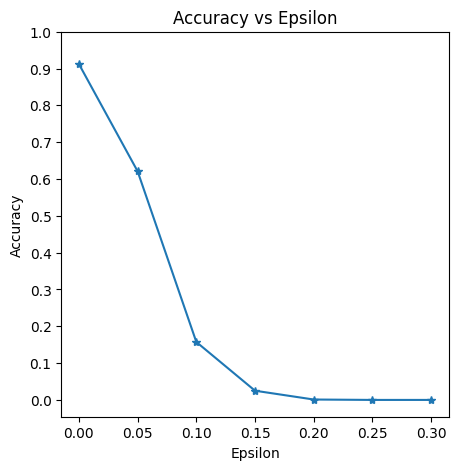

In [19]:
accuracies_logreg = []
examples_logreg = []

epsilons_logreg = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Run test for each epsilon
for eps in epsilons_logreg:
    acc, ex = evaluate_attack(model_logreg, criterion, dataset_test, eps)
    accuracies_logreg.append(acc)
    examples_logreg.append(ex)

plt.figure(figsize=(5, 5))
plt.plot(epsilons_logreg, accuracies_logreg, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Image quality

The code below explores the visual relationship between perturbation and image quality.

__Exercise__ How many perturbed images would you get right yourself?

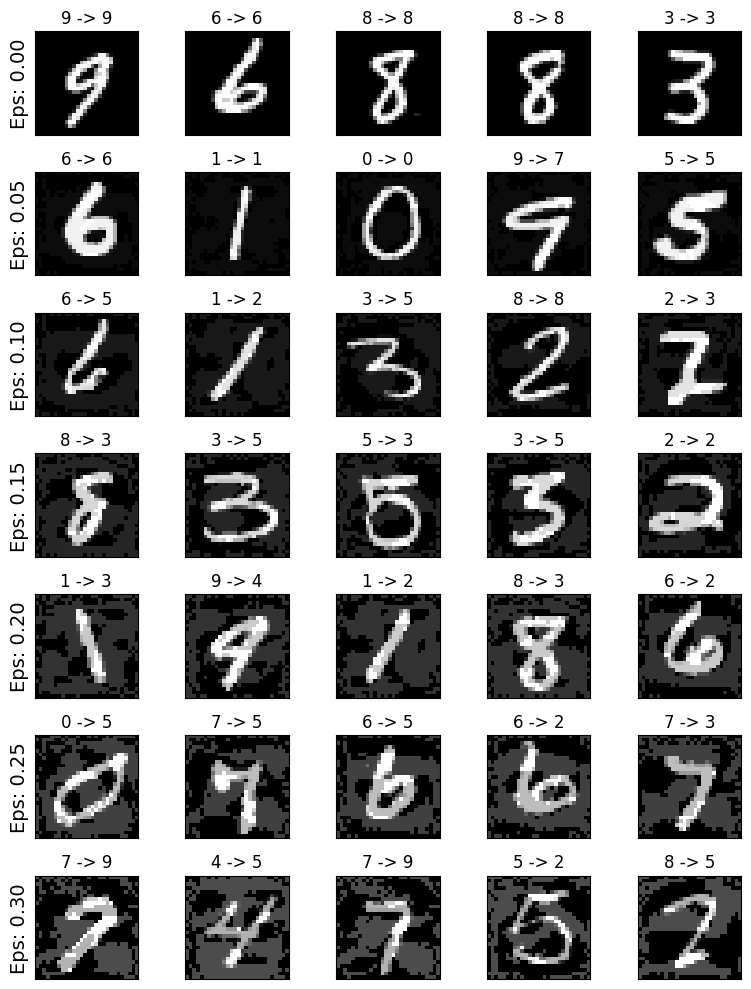

In [20]:
# Plot several examples of adversarial samples at each epsilon
counter = 0
plt.figure(figsize=(8, 10))
for epsilon, examples in zip(epsilons_logreg, examples_logreg):
    for column_number, example in enumerate(examples):
        counter += 1
        original_prediction, adversarial_prediction, img = example
        img = img.squeeze()

        plt.subplot(len(epsilons_logreg), len(examples), counter)

        plt.title("{} -> {}".format(original_prediction, adversarial_prediction))
        plt.imshow(img, cmap="gray")

        # Clear the axes
        plt.xticks([], [])
        plt.yticks([], [])

        # Print y-labels in the first column
        if column_number == 0:
            plt.ylabel("Eps: {:.2f}".format(epsilon), fontsize=14)

plt.tight_layout()
plt.show()

### Logistic regression vs a ConvNet
Now, let's run the same attack on the convolutional neural network you trained before.

__Exercise__ Find out which model is more robust to this type of adversarial perturbations. Does the result match your expectations? Can you intuitively explain the result? Do the adversarial examples look similar?

In [21]:
accuracies_lenet = []
examples_lenet = []

epsilons_lenet = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Run test for each epsilon
for eps in epsilons_lenet:
    acc, ex = evaluate_attack(model_lenet, criterion, dataset_test, eps)
    accuracies_lenet.append(acc)
    examples_lenet.append(ex)

Epsilon: 0.00	Test Accuracy = 0.981
Epsilon: 0.05	Test Accuracy = 0.929
Epsilon: 0.10	Test Accuracy = 0.801
Epsilon: 0.15	Test Accuracy = 0.547
Epsilon: 0.20	Test Accuracy = 0.229
Epsilon: 0.25	Test Accuracy = 0.090
Epsilon: 0.30	Test Accuracy = 0.037


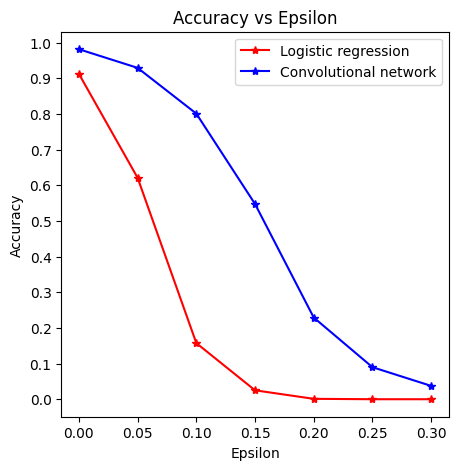

In [22]:
# Comparing the models
plt.figure(figsize=(5, 5))
plt.plot(epsilons_logreg, accuracies_logreg, "*-", c="red", label="Logistic regression")
plt.plot(
    epsilons_lenet, accuracies_lenet, "*-", c="blue", label="Convolutional network"
)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))

plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();

## 3. Training a neural network model robust to FGSM

[Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf) present an adversarial training algorithm using the Fast Gradient Sign Method to solve the inner maximization problem. The idea of FGSM training is simple: while training, adapt the training data to be a worst-case adversarial example by using the method developed before (details can be found in Section 5 of the [paper](https://arxiv.org/pdf/1412.6572.pdf)).

Training models that are robust against *any* adversarial input inside of some fixed $L_\infty$-ball can be sometimes tricky, and FGSM training is not always sufficient. Sometimes FGSM training leads to models which are robust only to FGSM, but not to other attacks. In case you are interested, see [this recent paper](https://arxiv.org/pdf/2007.02617.pdf) that discusses this issue in detail. More generally, accurate evaluation of adversarial robustness of neural networks is a complicated topic and many papers have been written on this (a good summary can be found [here](https://arxiv.org/abs/1902.06705)), and we won't go into more detail here, and we'll assume that FGSM attack is a good proxy for measuring the robustness of our model.


__Exercise__: Complete the code for FGSM adversarial training below. Use your `fgsm_update` function using perturbations which have $L_\infty$ distance of 0.25 to the original training images.

In [23]:
robust_neural_net_model = LeNetModel().to(device)

num_epochs = 10
optimizer = torch.optim.Adam(robust_neural_net_model.parameters(), lr=1e-3)
for epoch in range(num_epochs):
    # Train an epoch
    robust_neural_net_model.train()
    for batch_x, batch_y in dataset_train:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass for adversarial perturbations
        batch_x.requires_grad = True
        output = robust_neural_net_model(batch_x)
        original_predictions = output.argmax(1)  # get the index of the max logit
        original_accuracy = accuracy(output, batch_y)
        loss = criterion(output, batch_y)
        robust_neural_net_model.zero_grad()
        loss.backward()

        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        perturbed_data =  fgsm_update(batch_x, batch_x.grad, 0.25) # TODO: use your FGSM function here

        # Evaluate the network (forward pass)
        prediction = robust_neural_net_model(perturbed_data)
        loss = criterion(prediction, batch_y)

        # Compute the gradient
        optimizer.zero_grad()
        loss.backward()

        # Update the parameters of the model with a gradient step
        optimizer.step()

    # Test the quality on the test set
    robust_neural_net_model.eval()
    accuracies = []
    for batch_x, batch_y in dataset_test:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Evaluate the network (forward pass)
        prediction = robust_neural_net_model(batch_x)
        accuracies.append(accuracy(prediction, batch_y))

    print(
        "Epoch {:.2f} | Test accuracy: {:.5f}".format(
            epoch, sum(accuracies).item() / len(accuracies)
        )
    )


# training takes around two minutes
# you should expect an accuracy around 96%

Epoch 0.00 | Test accuracy: 0.80650
Epoch 1.00 | Test accuracy: 0.90350
Epoch 2.00 | Test accuracy: 0.91950
Epoch 3.00 | Test accuracy: 0.93620
Epoch 4.00 | Test accuracy: 0.94880
Epoch 5.00 | Test accuracy: 0.94960
Epoch 6.00 | Test accuracy: 0.94690
Epoch 7.00 | Test accuracy: 0.95300
Epoch 8.00 | Test accuracy: 0.95190
Epoch 9.00 | Test accuracy: 0.94400


Epsilon: 0.00	Test Accuracy = 0.944
Epsilon: 0.05	Test Accuracy = 0.912
Epsilon: 0.10	Test Accuracy = 0.875
Epsilon: 0.15	Test Accuracy = 0.839
Epsilon: 0.20	Test Accuracy = 0.814
Epsilon: 0.25	Test Accuracy = 0.792
Epsilon: 0.30	Test Accuracy = 0.760


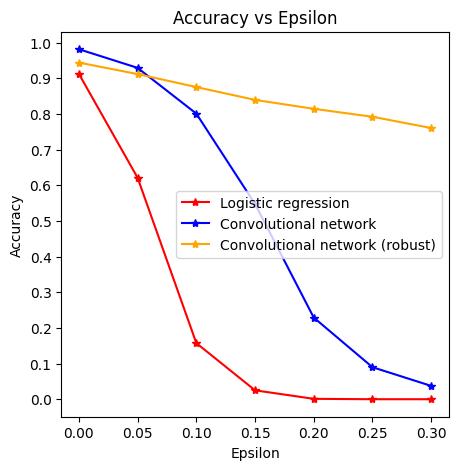

In [24]:
accuracies_lenet_robust = []
examples_lenet_robust = []

epsilons_lenet_robust = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Run test for each epsilon
for eps in epsilons_lenet_robust:
    acc, ex = evaluate_attack(robust_neural_net_model, criterion, dataset_test, eps)
    accuracies_lenet_robust.append(acc)
    examples_lenet_robust.append(ex)

# Comparing the models
plt.figure(figsize=(5, 5))
plt.plot(epsilons_logreg, accuracies_logreg, "*-", c="red", label="Logistic regression")
plt.plot(
    epsilons_lenet, accuracies_lenet, "*-", c="blue", label="Convolutional network"
)
plt.plot(
    epsilons_lenet_robust,
    accuracies_lenet_robust,
    "*-",
    c="orange",
    label="Convolutional network (robust)",
)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))

plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();

__Discussion__ Does adversarial training help to improve robustness against FGSM perturbations? Is there a trade-off between robustness and standard accuracy? Can you tune it to perform even better than with our default supplied parameters? How do you think the same defense would perform on the linear classification model (see Problem 1 in the current exercise sheet)?